In [2]:
#!pip install plotly
# ----- importing libraries needed
import numpy as np
import matplotlib
import scipy
import pylab
import netCDF4 as nc4
import numpy.ma as ma
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import struct
import glob
import pandas as pd
import datetime as dt
import random
import datetime
import plotly.plotly as py  # tools to communicate with Plotly's server
#import xarray as xr
from numpy import convolve
from cloudnetFunctions import CheckIceLiquidCloudnet
from cloudnetFunctions import f_calculateCloudMaskCloudnet

from myFunctions import f_closest
from myFunctions import getNearestIndex
from myFunctions import getIndexList
from myFunctions import getIndexListsuka
from myFunctions import getResampledDataPd
from myFunctions import hourDecimal_to_datetime
from myFunctions import f_calcTheta_MWR
%matplotlib inline  

In [3]:
#------ providing input directories
PathIn = '/Users/cacquist/Lavoro/PBL_hdcp2_s2/PBL_hdcp2_s2_minion/'
#'/Volumes/CLAMINION/PBL_hdcp2_s2/'
#PathIn = '/media/cacquist/CLAMINION/PBL_hdcp2_s2/'

year =2013
month=5
day=2
date='20130502'
Hcut = 3500.
Hsurf=107.
pathFig = PathIn+'figs/'

#------ reading input data from ICON, CLOUDNET, MWR data and PBL classification
#----------------------------------------------------------------------------------
# ----- reading ICON, CLOUDNET and PBL data
ICON_data = Dataset(PathIn+'PBL_properties_DOM03_20130502_JOYCE.nc', mode='r')
MWR_data = Dataset(PathIn+'130502_hps_l2a.nc', mode='r')
PRW_data = Dataset(PathIn+'130502_hps_l2a.nc', mode='r')
HUA_data = Dataset(PathIn+'130502_hph_l2b.nc', mode='r')
TA_data = Dataset(PathIn+'130502_hph_l2b.nc', mode='r')


# ----- reading MWR radiometer data variables for la and lb formats
time_MWR = MWR_data.variables['time'][:].copy()
LWP_MWR = MWR_data.variables['atmosphere_liquid_water_content'][:].copy()    # liquid water path [kg m^-2]
# creating time array for LWP in date time format
TA_MWR = TA_data.variables['tprof'][:].copy()         # air temperature [K]
HUA_MWR = HUA_data.variables['qprof'][:].copy()      # absolute humidity [kg m^-3]
IWV_MWR = PRW_data.variables['atmosphere_water_vapor_content'][:].copy()      # integrated water vapor [kg m^-2]
datetime_IWV = nc4.num2date(PRW_data.variables['time'][:],PRW_data.variables['time'].units)
datetime_HUA = nc4.num2date(HUA_data.variables['time'][:],HUA_data.variables['time'].units)
datetime_MWR = nc4.num2date(MWR_data.variables['time'][:],MWR_data.variables['time'].units) 
datetime_TA = nc4.num2date(TA_data.variables['time'][:],TA_data.variables['time'].units) 
height_HUA = HUA_data.variables['z'][:].copy()
height_TA = TA_data.variables['z'][:].copy()


# ----- reading tower measurements
from myFunctions import f_readingTowerData
tower_dict = f_readingTowerData(date, PathIn)
P_surf = tower_dict['P'][:]  # in Pascal
T_surf = tower_dict['Tsurf'][:] # in K
RH_surf = tower_dict['RHsurf'][:]
datetime_tower = tower_dict['time'][:]

# ----- reading ICON data variables
time_ICON = ICON_data.groups['Temp_data'].variables['datetime_ICON'][:].copy()

#time_ICON = time_ICON[np.where(time_ICON < 24.)[0]]   # cutting values larger than 24. in time
cloudMask_ICON = ICON_data.groups['Temp_data'].variables['cloudMask'][:]
#cloudMask_ICON2 = cloudMask_ICON[np.where(time_ICON < 24.)[0], :] # resize matrices accordingly
datetime_ICON = nc4.num2date(ICON_data.groups['Temp_data'].variables['datetime_ICON'][:],ICON_data.groups['Temp_data'].variables['datetime_ICON'].units) 
height_ICON = ICON_data.groups['Temp_data'].variables['height'][:].copy()
T_ICON = ICON_data.groups['Temp_data'].variables['T'][:].copy()





In [10]:
print(np.shape(P_surf))
print(np.shape(datetime_tower))

(144,)
(144,)


In [4]:
#------ regridding variables on ICON time grid
#---------------------------------------------------------------------------------
# ---- defining ICON data as dataframe reference
ICON_DF= pd.DataFrame(cloudMask_ICON, index=datetime_ICON, columns=height_ICON)

# ---- resamplig tower observations
print('resampling tower observations on ICON time resolution')
Psurf_DF = pd.DataFrame(P_surf, index=datetime_tower)
SelectedIndex_tower = getIndexList(Psurf_DF, ICON_DF.index)
values = np.arange(0, len(ICON_DF.index))
Psurf_resampled = pd.DataFrame(values, index=datetime_ICON)
Psurf_resampled = getResampledDataPd(Psurf_resampled, Psurf_DF, SelectedIndex_tower)

Tsurf_DF = pd.DataFrame(T_surf, index=datetime_tower)
SelectedIndex_tower_T = getIndexList(Tsurf_DF, ICON_DF.index)
values = np.arange(0, len(ICON_DF.index))
Tsurf_resampled = pd.DataFrame(values, index=datetime_ICON)
Tsurf_resampled = getResampledDataPd(Tsurf_resampled, Tsurf_DF, SelectedIndex_tower_T)


RHsurf_DF = pd.DataFrame(RH_surf, index=datetime_tower)
SelectedIndex_tower_RH = getIndexList(RHsurf_DF, ICON_DF.index)
values = np.arange(0, len(ICON_DF.index))
RHsurf_resampled = pd.DataFrame(values, index=datetime_ICON)
RHsurf_resampled = getResampledDataPd(RHsurf_resampled, RHsurf_DF, SelectedIndex_tower_RH)
print('resampled tower observations: Psurf, Tsurf, RHsurf')

# ---- resampling MWR LWP observations on ICON resolution
print('resampling MWR observations on ICON time resolution')

# ---- resampling LWP
LWP_DF = pd.DataFrame(LWP_MWR, index=datetime_MWR)
# ---- removing double values
LWP_DF = LWP_DF.reset_index().drop_duplicates(subset='index', keep='first').set_index('index')
SelectedIndex_MWR = getIndexList(LWP_DF, ICON_DF.index)
values = np.arange(0, len(ICON_DF.index))
MWR_resampled = pd.DataFrame(values, index=datetime_ICON)
MWR_resampled = getResampledDataPd(MWR_resampled, LWP_DF, SelectedIndex_MWR)

# ---- resampling IWV
IWV_DF = pd.DataFrame(IWV_MWR, index=datetime_IWV)
# ---- removing double values
IWV_DF = IWV_DF.reset_index().drop_duplicates(subset='index', keep='first').set_index('index')
SelectedIndex_IWV = getIndexList(IWV_DF, ICON_DF.index)
IWV_resampled = pd.DataFrame(values, index=datetime_ICON)
IWV_resampled = getResampledDataPd(IWV_resampled, IWV_DF, SelectedIndex_IWV)

# ---- resampling T
TA_DF = pd.DataFrame(TA_MWR, index=datetime_TA)
# ---- removing double values
TA_DF = TA_DF.reset_index().drop_duplicates(subset='index', keep='first').set_index('index')
values_TA = np.zeros((len(datetime_ICON),len(height_TA)))
SelectedIndex_TA = getIndexList(TA_DF, ICON_DF.index)
TA_resampled = pd.DataFrame(values_TA, index=datetime_ICON)
TA_resampled = getResampledDataPd(TA_resampled, TA_DF, SelectedIndex_TA)


# ---- resampling absolute humidity
QA_DF = pd.DataFrame(HUA_MWR, index=datetime_HUA)
# ---- removing double values
QA_DF = QA_DF.reset_index().drop_duplicates(subset='index', keep='first').set_index('index')
values_HUA = np.zeros((len(datetime_ICON),len(height_HUA)))
SelectedIndex_QA = getIndexList(QA_DF, ICON_DF.index)
QA_resampled = pd.DataFrame(values_HUA, index=datetime_ICON)
QA_resampled = getResampledDataPd(QA_resampled, QA_DF, SelectedIndex_QA)


print('MWR radiometer variables resampled: LWP, IWV, T, Q')

resampling tower observations on ICON time resolution
resampled tower observations: Psurf, Tsurf, RHsurf
resampling MWR observations on ICON time resolution
MWR radiometer variables resampled: LWP, IWV, T, Q


In [13]:
print(np.shape(Psurf_resampled.values))

(9601, 1)


In [5]:
# --- Defining constants needed for calc
Cp = 1004.
Rw = 462.
Rl = 287.
g = 9.81

# --- calculating virtual temperature in K
T = TA_resampled.values
q = QA_resampled.values
Tv = np.zeros((len(datetime_ICON),len(height_TA)))
for indTime in range(len(datetime_ICON)):
    for indHeight in range(len(height_TA)):
        Tv[indTime,indHeight] = T[indTime,indHeight] + 0.608 * q[indTime,indHeight]

                    

In [58]:

    
# --- calculating pressure at each level using barometric height formula in Pascal
Pbaro = np.zeros((len(datetime_ICON),len(height_TA)))

for indTime in range(len(datetime_ICON)):
    for indHeight in range(len(height_TA)):
        if indHeight == 0:
            Pbaro[indTime, indHeight] = Psurf_resampled.values[indTime]
        else:
            dz = height_TA[indHeight] - height_TA[indHeight-1]
            deltaT = Tv[indTime,indHeight]+Tv[indTime,indHeight-1]
                #print(dz)
                #print(deltaT)
            Pbaro[indTime, indHeight] = Pbaro[indTime, indHeight-1] *np.exp(-g*(dz)/(Rl*(deltaT)/2))
    
print(Pbaro[0:10])

[[ 100826.          100221.20665043   99620.00508561   99022.22946074
    98427.80030077   97836.69058232   96956.15436642   96082.78021332
    95216.34696368   94356.68143516   93503.65053531   92657.17810766
    91538.61709738   90431.36113427   89335.24554874   87711.67145606
    86112.5274913    84537.66101139   82986.92742721   80956.45848784
    78967.86463321   76539.93183277   74174.94229239   71871.48814922
    69628.08990911   67443.05041236   65314.86483002   63242.15604369
    61223.45150459   59257.40007551   57342.65865343   55477.98314006
    53662.20925655   50172.62137545   46865.00618788   43730.92718262
    40762.56962256   37952.98272585   35295.96482524   32785.84189724
    30417.87405622   28188.64351714   26096.18769405]
 [ 100826.          100221.20665043   99620.00508561   99022.22946074
    98427.80030077   97836.69058232   96956.15436642   96082.78021332
    95216.34696368   94356.68143516   93503.65053531   92657.17810766
    91538.61709738   90431.36113427 

In [51]:
# --- calculating theta Td, mixing ratio, partial water vapor pressure, theta_eq, mixing ratio at the surface for t=td
Theta = np.zeros((len(datetime_ICON),len(height_TA)))
Theta_e = np.zeros((len(datetime_ICON),len(height_TA)))
Td = np.zeros((len(datetime_ICON),len(height_TA)))
mr = np.zeros((len(datetime_ICON),len(height_TA)))



cost_rlv= 5423.**(-1) # K^-1 (Lv/Rv)
e0 = 0.611 # Kpa
T0 = 273.15 # K   


for indTime in range(len(datetime_ICON)):
    for indHeight in range(len(height_TA)):
        Theta[indTime, indHeight] = T[indTime, indHeight]*(np.power(100000./Pbaro[indTime, indHeight], Rl/Cp)) # potential temperature in K
        
        e = 462.*T[indTime, indHeight]*q[indTime, indHeight] # partial water vapor pressure in Pa
        
        mr[indTime, indHeight] = 0.622*e/(Pbaro[indTime, indHeight]-e) # water vapor mixing ratio in kg/kg
        
        lv = (2500.-2.42*(T[indTime, indHeight]-273.15))*1000. # latent heat of vaporization in J/kg
        
        Theta_e[indTime, indHeight] = Theta[indTime, indHeight]+(lv*mr[indTime, indHeight]/Cp) \
        *(np.power(100000./Pbaro[indTime, indHeight], Rl/Cp)) # equivalent potential temperature in K
        
        Td[indTime, indHeight] = (T0**(-1) - cost_rlv * (np.log((e*(10.**(-3)))/e0)))**(-1)
        
        
        


In [65]:
# ---- calculating the saturation mixing ratio for td at the surface (assuming RH =100%)
# defining constants
cost_rvl = np.power(5423,-1.) #K
Rv = 461 # J K^-1 Kg^-1
epsilon = 0.622  # g (vapor)/ g (dry air)
P2use = np.array(Psurf_resampled.values)

M0 =[]
for IndTime in range(len(datetime_ICON)):
    M0.append(epsilon*e0*np.exp((1./Rv)*(T0**(-1.)-Td[IndTime,0]**(-1.))) / \
(P2use[IndTime]*(10**(-3)) - e0*np.exp((1./Rv)*(T0**(-1.)-Td[IndTime,0]**(-1.)))) )


0.00866299669555


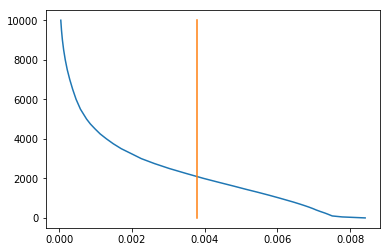

In [69]:
pippo = M0[5000]
print(np.max(mr))
plt.plot(mr[5000,:], height_TA)
plt.plot(np.repeat(pippo,len(height_TA)), height_TA)

In [78]:
# --- calculating z_ccl and T_ccl

# calculating at which height the mixing ratio crosses the surface value
ind_CCL = []
for indTime in range(len(datetime_ICON)):
    for indHeight in range(1, len(height_TA)-1):
        #print(height_ICON[indHeight])
        if ((mr[indTime,indHeight] < M0[indTime]) and (mr[indTime,indHeight-1] > M0[indTime])):
            ind_CCL.append(indHeight)
            break

z_ccl = height_TA[ind_CCL]
print(z_ccl)


Ad_rate = -9.8 # K/Km
T_ground_CCL = []
# ---- finding z(CCL) using the dry adiabatic lapse rate
for indTime in range(len(datetime_ICON)):
    T_top = T[indTime, ind_CCL[indTime]]
    T_ground_CCL.append(T_top - Ad_rate* z_ccl[indTime]*10.**(-3))
T_ground_CCL

[ 2000.  2000.  2000. ...,  2000.  2000.  2000.]


[293.9212585449219,
 293.9212585449219,
 293.9212585449219,
 293.9212585449219,
 293.9212585449219,
 293.9212585449219,
 293.9212585449219,
 293.9212585449219,
 293.9212585449219,
 293.9212585449219,
 293.9212585449219,
 293.9212585449219,
 293.9212585449219,
 293.9212585449219,
 293.9212585449219,
 294.13533935546877,
 294.13533935546877,
 294.13533935546877,
 294.13533935546877,
 294.13533935546877,
 294.13533935546877,
 294.13533935546877,
 294.13533935546877,
 294.13533935546877,
 294.13533935546877,
 294.13533935546877,
 294.13533935546877,
 294.13533935546877,
 294.13533935546877,
 294.13533935546877,
 294.13533935546877,
 294.13533935546877,
 294.13533935546877,
 294.21865234375002,
 294.21865234375002,
 294.21865234375002,
 294.21865234375002,
 294.21865234375002,
 294.21865234375002,
 294.21865234375002,
 294.21865234375002,
 294.21865234375002,
 294.21865234375002,
 294.21865234375002,
 294.21865234375002,
 294.21865234375002,
 294.21865234375002,
 294.21865234375002,
 294.21

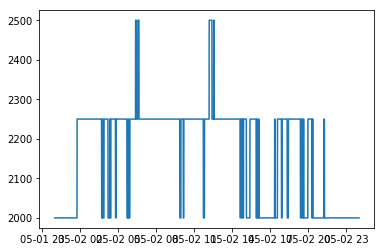

In [76]:
plt.plot(datetime_ICON, z_ccl)

(734990.25, 734990.8333333334)

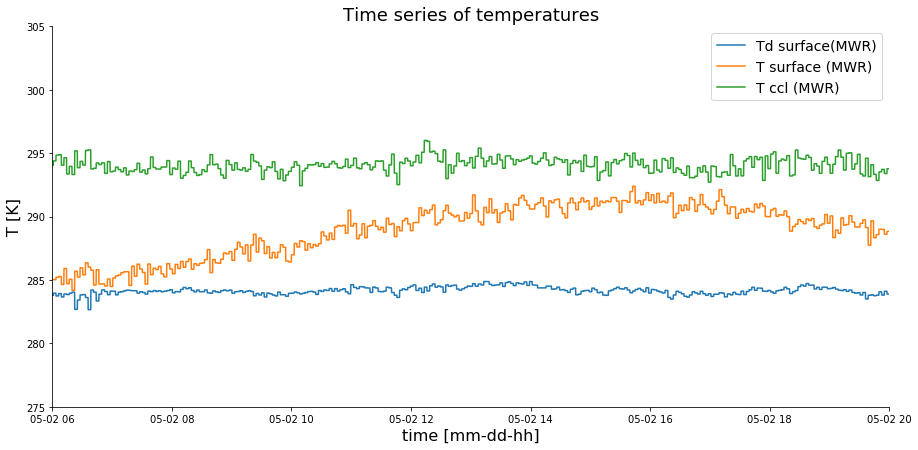

In [79]:
fig, ax = plt.subplots(figsize=(15,7))
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
plt.plot(datetime_ICON, Td[:,0], label='Td surface(MWR)')
plt.plot(datetime_ICON, T[:,0], label='T surface (MWR)')
plt.plot(datetime_ICON, T_ground_CCL, label='T ccl (MWR)')
plt.legend(loc='upper right', fontsize=14)
plt.title('Time series of temperatures', fontsize=18)
plt.ylabel('T [K]', fontsize=16)
plt.ylim(275., 305.)
plt.xlabel('time [mm-dd-hh]', fontsize=16)
plt.xlim(datetime.datetime(2013,5,2,6,0,0),datetime.datetime(2013,5,2,20,0,0))

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
ax.set_ylim(0.,3000.) 
cax = ax.pcolormesh(datetime_ICON, height_TA, mr.transpose(), vmin=0., vmax=0.008)
cbar = fig.colorbar(cax)
cbar.set_label(label="mixing ratio",size=12)